In [1]:
import pandas as pd

import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 18.0)

pd.pandas.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("precision", 3)
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('fivethirtyeight')

import gc
gc.collect()

4

In [2]:
labels = pd.read_csv(r"dengue_labels_train.csv", low_memory=False)
feats = pd.read_csv(r"dengue_features_train.csv", low_memory=False)

df = pd.merge(feats, labels, on=['city', 'year', 'weekofyear'])

df['week_start_date'] = pd.to_datetime(df['week_start_date'], errors='coerce')
df.sort_values(by=['week_start_date'], inplace=True)
df.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.80,295.90,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.40,20.00,16.00,4
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.90,296.40,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.70,22.20,8.60,5
2,sj,1990,20,1990-05-14,0.03,0.17,0.16,0.17,34.54,298.78,298.88,295.43,300.50,297.30,26.10,82.05,34.54,16.85,2.30,26.71,6.49,32.20,22.80,41.40,4


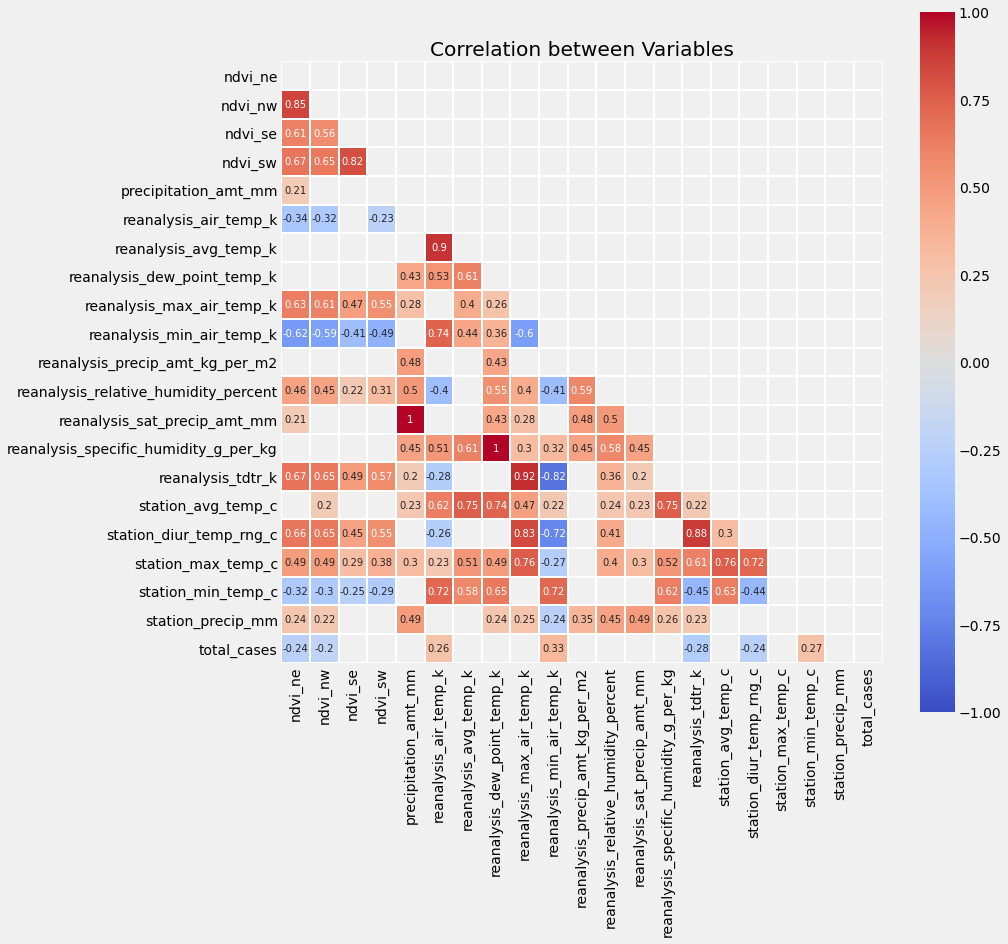

In [3]:
def find_correlation(df, limits=0.2):
    df = df.drop(['year', 'weekofyear'], axis=1)
    corr = df.corr()
    corr = corr[(corr >= limits) | (corr <= -limits)] 
    corr = round(corr, 2)
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    fig, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, cmap='coolwarm', annot=True, ax=ax, mask=mask, 
                     vmax=1.0, vmin=-1.0, linewidths=0.1,
                    annot_kws={"size": 10}, square=True); 
    
    ax.set_title('Correlation Heatmap', fontdict={'fontsize': 6}, pad=12);
    ax.set_title("Correlation between Variables");
    plt.savefig("corr.png", dpi = 300)
    plt.show();

find_correlation(df)

#### Highly correlated features

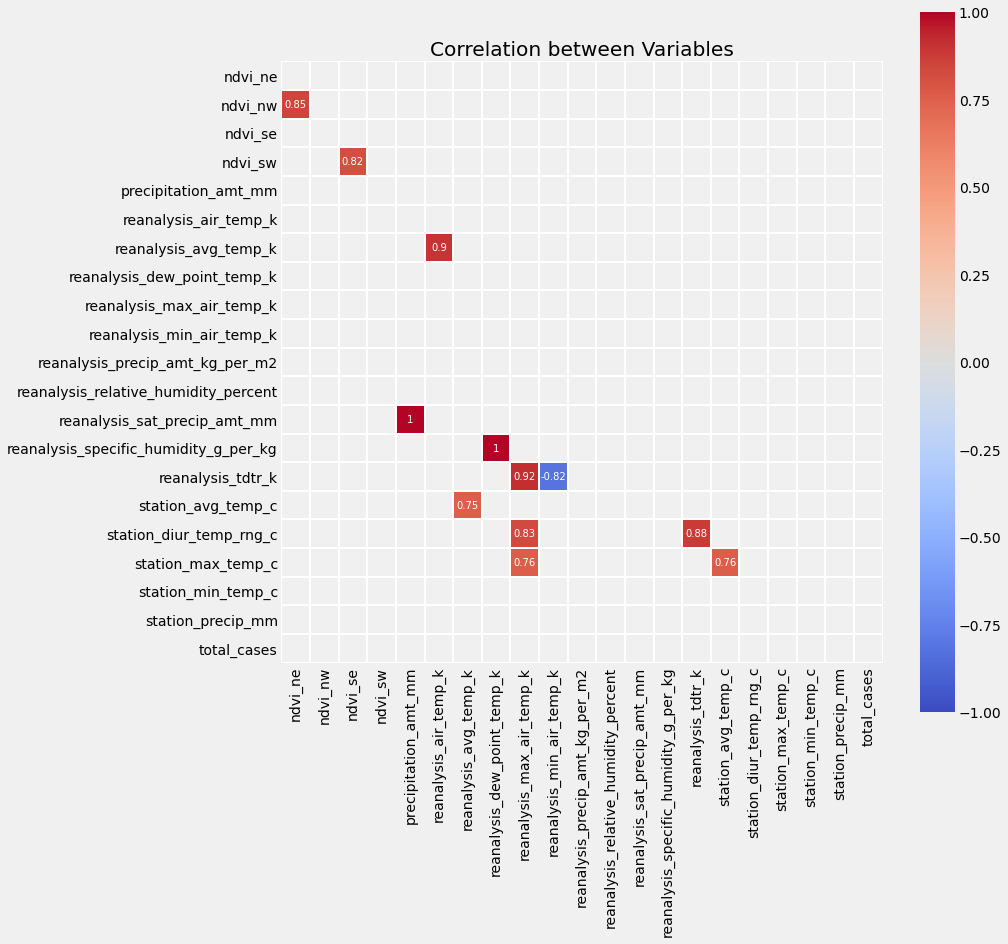

In [4]:
find_correlation(df, limits=0.75)

In [5]:
reg = LassoCV(max_iter=2000, n_jobs=-1)

df_ = df.copy()
df_.dropna(inplace=True)

X = df_.drop(["total_cases", 'week_start_date'], axis=1)
X = pd.get_dummies(X, columns = ['city', 'year', 'weekofyear'], drop_first=True)
y = df_['total_cases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X_test, y_test))
coef = pd.Series(reg.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.137308
Best score using built-in LassoCV: 0.437115


In [6]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 50 variables and eliminated the other 42 variables


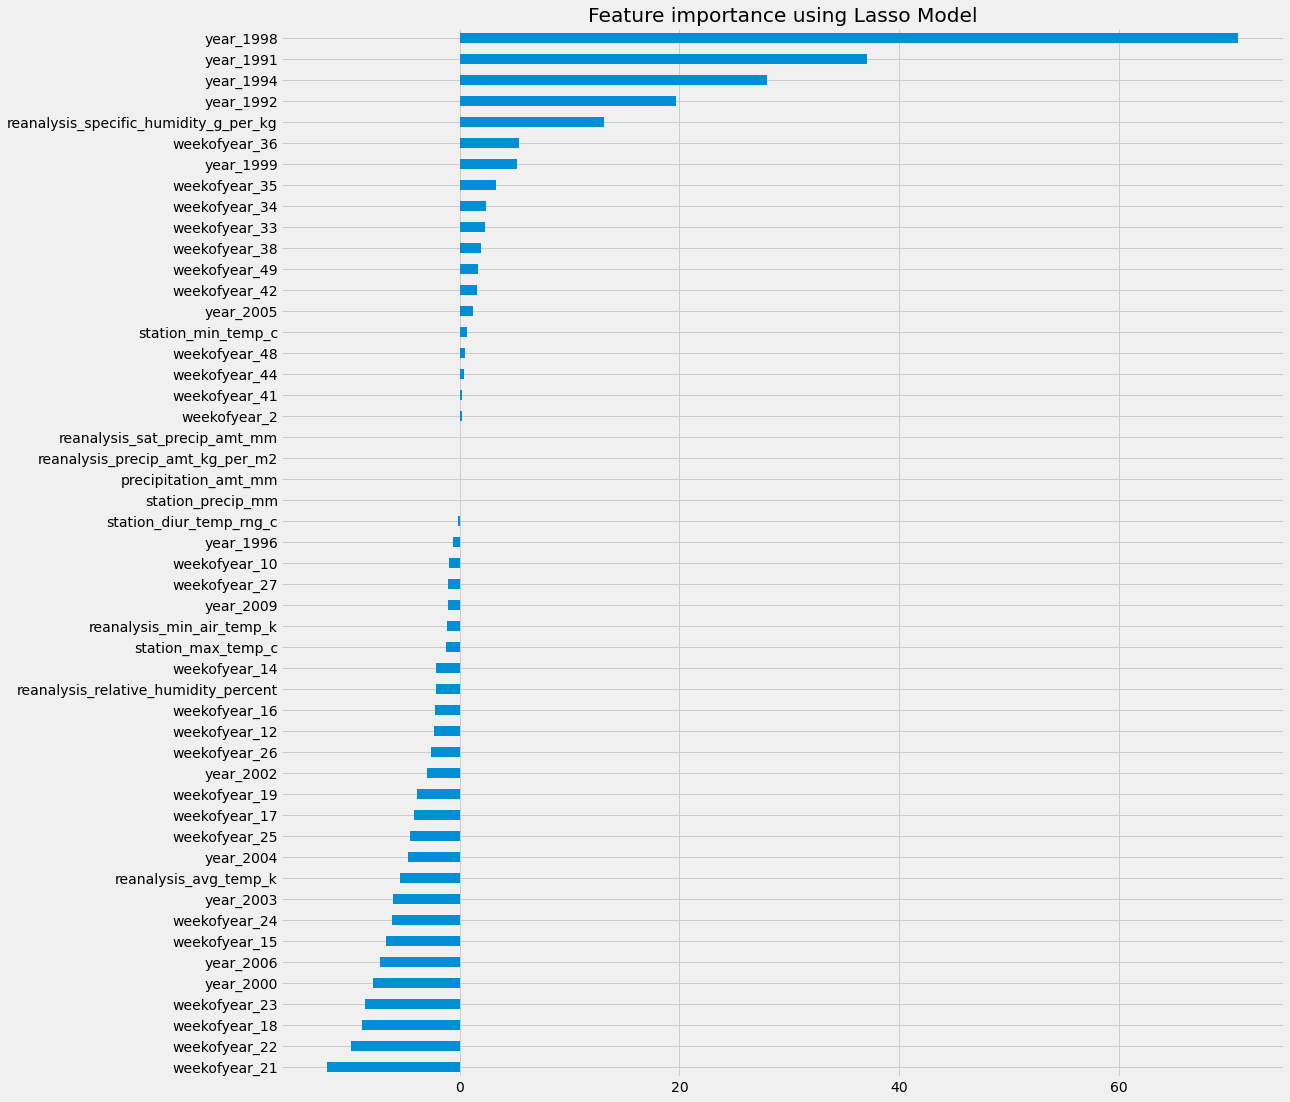

In [7]:
imp_coef = coef.sort_values()
imp_coef = imp_coef[imp_coef != 0]

imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model");

In [8]:
%%time

nof_list = np.arange(1, X.shape[1])            
high_score=0

nof=0           
score_list =[]

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    model = RandomForestRegressor(n_estimators=20, n_jobs=-1, max_depth=3, random_state=42)
    
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 88
Score with 88 features: 0.435418
CPU times: user 5min 52s, sys: 1min 3s, total: 6min 55s
Wall time: 3min 12s


In [9]:
cols = list(X.columns)
model = LinearRegression()

rfe = RFE(model, 72)             

X_rfe = rfe.fit_transform(X, y)

model.fit(X_rfe, y)            
support = pd.Series(rfe.support_, index = cols)
selected_features_rfe = support[support == True].index
print(selected_features_rfe.tolist())

['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'city_sj', 'year_1991', 'year_1992', 'year_1993', 'year_1994', 'year_1996', 'year_1998', 'year_1999', 'year_2000', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2009', 'weekofyear_2', 'weekofyear_3', 'weekofyear_5', 'weekofyear_6', 'weekofyear_7', 'weekofyear_9', 'weekofyear_10', 'weekofyear_11', 'weekofyear_12', 'weekofyear_13', 'weekofyear_14', 'weekofyear_15', 'weekofyear_16', 'weekofyear_17', 'weekofyear_18', 'weekofyear_19', 'weekofyear_20', 'weekofyear_21', 'weekofyear_22', 'weekofyear_23', 'weekofyear_24', 'weekofyear_25', 'weekofyear_26', 'weekofyear_27', 'weekofyear_28', 'weekofyear_29', 'weekofyear_31', 'weekofyear_32', 'weekofyear_33', 'weekofyear_34', 'weekofyear_35', 'weekofyear_36', 'weekofyear_37', 'weekofyear_38',

#### Common important features from both

In [10]:
set(imp_coef.index.tolist()).intersection(set(selected_features_rfe.tolist()))

{'precipitation_amt_mm',
 'reanalysis_avg_temp_k',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'weekofyear_10',
 'weekofyear_12',
 'weekofyear_14',
 'weekofyear_15',
 'weekofyear_16',
 'weekofyear_17',
 'weekofyear_18',
 'weekofyear_19',
 'weekofyear_2',
 'weekofyear_21',
 'weekofyear_22',
 'weekofyear_23',
 'weekofyear_24',
 'weekofyear_25',
 'weekofyear_26',
 'weekofyear_27',
 'weekofyear_33',
 'weekofyear_34',
 'weekofyear_35',
 'weekofyear_36',
 'weekofyear_38',
 'weekofyear_41',
 'weekofyear_42',
 'weekofyear_44',
 'weekofyear_48',
 'weekofyear_49',
 'year_1991',
 'year_1992',
 'year_1994',
 'year_1996',
 'year_1998',
 'year_1999',
 'year_2000',
 'year_2002',
 'year_2003',
 'year_2004',
 'year_2005',
 'year_2006',
 'year_2009'}

In [11]:
X = X[sorted(set(imp_coef.index.tolist()).intersection(set(selected_features_rfe.tolist())))]
X.shape

(1199, 43)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

model = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_depth=3, oob_score=True, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = model.score(X_test, y_test)
oob = model.oob_score_
print("R2 Score: %f" % score)
print("OOB Score: %f" % oob)

R2 Score: 0.409716
OOB Score: 0.340574


In [13]:
from sklearn import metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred), 2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred), 2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))
print('Std. Dev of test data:', round(np.std(y_test), 2))

Mean Absolute Error: 13.81
Mean Squared Error: 434.75
Root Mean Squared Error: 20.85
Std. Dev of test data: 27.14


Next Steps:
- Deep dive on features.
- Impute missing values intelligently.
- Understand Feature-Interaction.
- Improve over baseline model.